In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import json
import joblib


In [4]:
df = pd.read_csv("S06-hw-dataset-03.csv")
df.head()
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      15000 non-null  int64  
 1   f01     15000 non-null  float64
 2   f02     15000 non-null  float64
 3   f03     15000 non-null  float64
 4   f04     15000 non-null  float64
 5   f05     15000 non-null  float64
 6   f06     15000 non-null  float64
 7   f07     15000 non-null  float64
 8   f08     15000 non-null  float64
 9   f09     15000 non-null  float64
 10  f10     15000 non-null  float64
 11  f11     15000 non-null  float64
 12  f12     15000 non-null  float64
 13  f13     15000 non-null  float64
 14  f14     15000 non-null  float64
 15  f15     15000 non-null  float64
 16  f16     15000 non-null  float64
 17  f17     15000 non-null  float64
 18  f18     15000 non-null  float64
 19  f19     15000 non-null  float64
 20  f20     15000 non-null  float64
 21  f21     15000 non-null  float64
 22

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f20,f21,f22,f23,f24,f25,f26,f27,f28,target
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,-0.840416,-0.011530,0.755463,0.008092,-0.246559,0.992538,-0.004599,-0.005366,0.011024,...,0.008801,0.004798,-0.060611,-0.008095,0.002397,0.699377,-0.001170,1.380216,0.150765,0.612600
std,4330.271354,1.785432,1.007374,3.663136,0.996556,2.216202,3.943110,2.113607,1.001960,1.006309,...,0.988931,0.999959,3.747823,0.994912,0.990567,3.801468,0.996588,3.929134,2.005847,0.740016
min,1.000000,-8.199174,-4.100091,-13.591257,-3.992807,-8.243563,-14.950758,-8.522298,-3.768197,-3.791645,...,-3.612116,-4.150852,-15.977469,-3.664246,-3.857890,-16.273835,-4.536600,-12.105957,-8.300728,0.000000
25%,3750.750000,-2.029608,-0.686265,-1.593729,-0.674039,-1.738188,-1.580544,-1.380091,-0.673001,-0.661451,...,-0.674236,-0.669654,-2.517892,-0.676471,-0.661098,-1.842677,-0.668133,-1.339314,-1.235425,0.000000
50%,7500.500000,-0.855943,-0.010454,0.744919,0.009431,-0.203512,1.110848,0.134466,-0.003663,0.004158,...,0.020916,0.010701,0.019034,-0.001622,0.001807,0.780608,-0.007763,1.108728,0.137089,0.000000
75%,11250.250000,0.313482,0.674347,3.057234,0.677459,1.254102,3.700201,1.443666,0.662753,0.683465,...,0.681036,0.676786,2.521745,0.659456,0.663270,3.297387,0.676626,3.869991,1.524830,1.000000
max,15000.000000,7.338969,4.418126,17.965154,3.887820,8.542916,15.618988,7.575797,3.698010,3.963730,...,3.497004,3.828639,12.661894,4.214633,4.378893,17.152063,3.618447,18.906060,8.007400,2.000000


In [5]:
df.isna().sum().sort_values(ascending=False)

df["target"].value_counts()

,count
target,
0,8138
1,4535
2,2327


In [6]:
X = df.drop(columns=["target", "id"], errors = "ignore")
y = df["target"]

X.shape, y.shape

((15000, 28), (15000,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state = 42,
    stratify = y
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((11250, 28), (3750, 28), np.float64(0.6125333333333334), np.float64(0.6128))

мы фиксируем случайность разбиения, чтобы при каждом запуске получались одинаковые train/test. это нужно для правильного сравнения моделей и воспроизводимости результата

стратификация важна, потому что она сохраняет пропорции классво в train и test. без этого можно случайно получить неправильный test, и метрики будут неверными

In [8]:
# DummyClassifier

dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
dummy_pred_bin = lb.transform(dummy_pred)

In [9]:
roc_score = roc_auc_score(y_test_bin, dummy_pred_bin, multi_class='ovr', average='macro')
accuracy = accuracy_score(y_test, dummy_pred)
f1 = f1_score(y_test, dummy_pred, average="macro")
print(f"accuracy for dummy bro: {accuracy}")
print(f"f1 for dummy bro: {f1}")
print(f"auc for dummy bro: {roc_score}")

accuracy for dummy bro: 0.40453333333333336
f1 for dummy bro: 0.3283980742103863
auc for dummy bro: 0.496042196064942


dummy - это базовая нулевая модель, которая вообще не учится и выбирает самый частый класс. любая модель должна быть лучше этой глупой модели.

In [10]:
# LogisticRegression

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000, random_state=42))
])
logreg.fit(X_train, y_train)
log_pred = logreg.predict(X_test)
logreg_proba = logreg.predict_proba(X_test)

In [11]:
logreg_acc = accuracy_score(y_test, log_pred)
logreg_f1 = f1_score(y_test, log_pred, average="macro")
logreg_auc = roc_auc_score(y_test, logreg_proba, multi_class='ovr')
print(f"logreg accuracy: {logreg_acc}")
print(f"logreg f1: {logreg_f1}")
print(f"logreg auc: {logreg_auc}")

logreg accuracy: 0.72
logreg f1: 0.6632634159041243
logreg auc: 0.8467788482997881


In [12]:
# результаты baseline
baseline_results = {
    'Dummy_stratified': {
        'accuracy': float(accuracy),
        'f1_macro': float(f1),
        'roc_auc_ovr': float(roc_score)
    },
    'LogisticRegression': {
        'accuracy': float(logreg_acc),
        'f1_macro': float(logreg_f1),
        'roc_auc_ovr': float(logreg_auc)
    }
}

логистическая регрессия - довольно быстрый и сильный baseline. масштабирование признаков нужно, чтобы модель работала при разных порядков величин у фич.

In [13]:
dt_param_grid = {
    'max_depth': [7, 10, 15],
    'min_samples_leaf': [4, 8, 16],
    'ccp_alpha': [0.0, 0.001, 0.01]
}
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)

print(f"best params: {dt_grid.best_params_}")
print(f"best CV score: {dt_grid.best_score_}")

dt_best = dt_grid.best_estimator_
dt_test_pred = dt_best.predict(X_test)
dt_test_accuracy = accuracy_score(y_test, dt_test_pred)
dt_test_f1 = f1_score(y_test, dt_test_pred, average='macro')
dt_test_proba = dt_best.predict_proba(X_test)
dt_test_auc = roc_auc_score(y_test, dt_test_proba, multi_class='ovr')

print(f"accuracy: {dt_test_accuracy}")
print(f"f1 (macro): {dt_test_f1}")
print(f"ROC-AUC (ovr): {dt_test_auc}")
print(f"depth: {dt_best.get_depth()}")
print(f"leaves: {dt_best.get_n_leaves()}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
best params: {'ccp_alpha': 0.0, 'max_depth': 15, 'min_samples_leaf': 8}
best CV score: 0.7277319032295219
accuracy: 0.7957333333333333
f1 (macro): 0.7489412237858829
ROC-AUC (ovr): 0.8627944089902314
depth: 15
leaves: 546


In [14]:
model_results = {}
search_summaries = {}

model_results['DecisionTree'] = {
    'accuracy': float(dt_test_accuracy),
    'f1_macro': float(dt_test_f1),
    'roc_auc_ovr': float(dt_test_auc)
}
search_summaries['DecisionTree'] = {
    'best_params': dt_grid.best_params_,
    'best_cv_score': float(dt_grid.best_score_)
}

In [15]:
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"best params: {rf_grid.best_params_}")
print(f"best CV score: {rf_grid.best_score_:.4f}")

rf_best = rf_grid.best_estimator_
rf_test_pred = rf_best.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
rf_test_f1 = f1_score(y_test, rf_test_pred, average='macro')
rf_test_proba = rf_best.predict_proba(X_test)
rf_test_auc = roc_auc_score(y_test, rf_test_proba, multi_class='ovr')

print(f"accuracy: {rf_test_accuracy:.4f}")
print(f"f1 (macro): {rf_test_f1:.4f}")
print(f"ROC-AUC (ovr): {rf_test_auc:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
best CV score: 0.8291
accuracy: 0.8813
f1 (macro): 0.8517
ROC-AUC (ovr): 0.9503


In [16]:
model_results['RandomForest'] = {
    'accuracy': float(rf_test_accuracy),
    'f1_macro': float(rf_test_f1),
    'roc_auc_ovr': float(rf_test_auc)
}
search_summaries['RandomForest'] = {
    'best_params': rf_grid.best_params_,
    'best_cv_score': float(rf_grid.best_score_)
}

In [17]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

In [18]:
# GradientBoostingClassifier
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 0.9]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=2,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

print(f"best params: {gb_grid.best_params_}")
print(f"best CV score: {gb_grid.best_score_:.4f}")

gb_best = gb_grid.best_estimator_
gb_test_pred = gb_best.predict(X_test)
gb_test_accuracy = accuracy_score(y_test, gb_test_pred)
gb_test_f1 = f1_score(y_test, gb_test_pred, average='macro')
gb_test_proba = gb_best.predict_proba(X_test)
gb_test_auc = roc_auc_score(y_test, gb_test_proba, multi_class='ovr')


print(f"accuracy: {gb_test_accuracy:.4f}")
print(f"f1 (macro): {gb_test_f1:.4f}")
print(f"ROC-AUC (ovr): {gb_test_auc:.4f}")

Fitting 2 folds for each of 32 candidates, totalling 64 fits
best params: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.9}
best CV score: 0.8178
accuracy: 0.8691
f1 (macro): 0.8386
ROC-AUC (ovr): 0.9471


In [19]:
model_results['GradientBoosting'] = {
    'accuracy': float(gb_test_accuracy),
    'f1_macro': float(gb_test_f1),
    'roc_auc_ovr': float(gb_test_auc)
}
search_summaries['GradientBoosting'] = {
    'best_params': gb_grid.best_params_,
    'best_cv_score': float(gb_grid.best_score_)
}

In [20]:
all_results = {**baseline_results, **model_results}


results_df = pd.DataFrame(all_results).T
results_df_sorted = results_df.sort_values('f1_macro', ascending=False)
print("по F1-score (макро):")

for i, (model, row) in enumerate(results_df_sorted.iterrows(), 1):
    print(f"{i}. {model:20} : f1={row['f1_macro']:.4f}, accuracy={row['accuracy']:.4f}")

best_model_name = results_df_sorted.index[0]
best_model_score = results_df_sorted.iloc[0]['f1_macro']

print(f"\nbest model: {best_model_name}")
print(f"f1-score (macro): {best_model_score:.4f}")

по F1-score (макро):
1. RandomForest         : f1=0.8517, accuracy=0.8813
2. GradientBoosting     : f1=0.8386, accuracy=0.8691
3. DecisionTree         : f1=0.7489, accuracy=0.7957
4. LogisticRegression   : f1=0.6633, accuracy=0.7200
5. Dummy_stratified     : f1=0.3284, accuracy=0.4045

best model: RandomForest
f1-score (macro): 0.8517


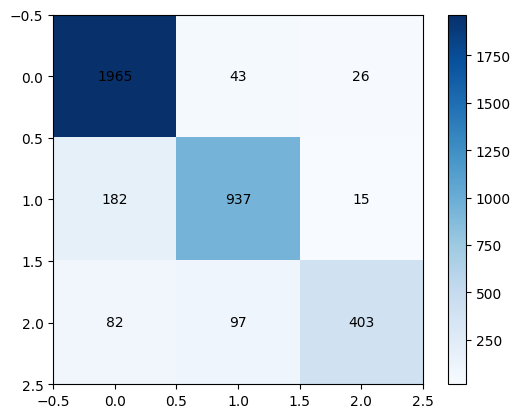

In [21]:
best_model = rf_best
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

/tmp/ipython-input-199367880.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=45, ha='right')
/tmp/ipython-input-199367880.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45, ha='right')


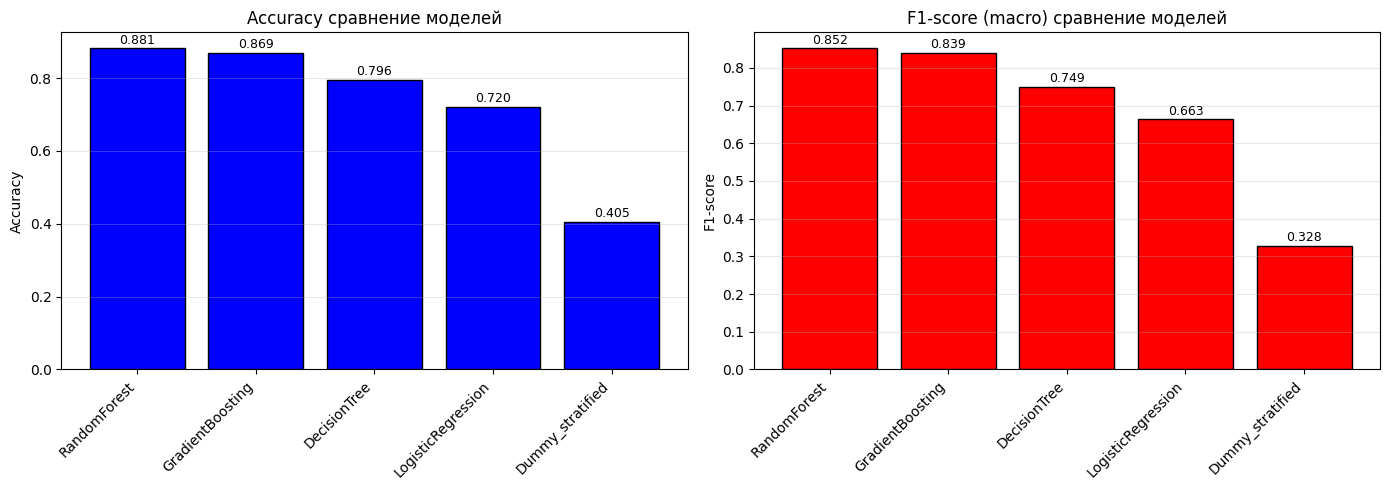

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax1 = axes[0]
models = results_df_sorted.index
acc_values = results_df_sorted['accuracy'].values
bars1 = ax1.bar(models, acc_values, color='blue', edgecolor='black')
ax1.set_title('Accuracy сравнение моделей')
ax1.set_ylabel('Accuracy')
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars1, acc_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax2 = axes[1]
f1_values = results_df_sorted['f1_macro'].values
bars2 = ax2.bar(models, f1_values, color='red', edgecolor='black')
ax2.set_title('F1-score (macro) сравнение моделей')
ax2.set_ylabel('F1-score')
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, f1_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('artifacts/figures/metrics_comparison.png', dpi=100)
plt.show()


Важность признаков RandomForest


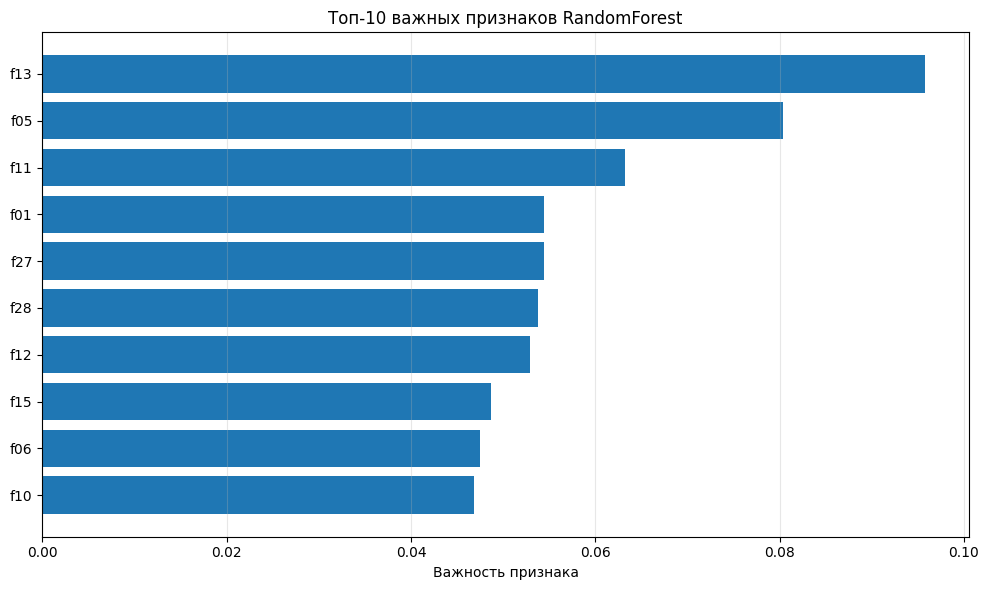

In [23]:
print("\nВажность признаков RandomForest")

plt.figure(figsize=(10, 6))
top_n = min(10, len(feature_importance))
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['importance'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Важность признака')
plt.title(f'Топ-{top_n} важных признаков RandomForest')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('artifacts/figures/feature_importance.png', dpi=100)
plt.show()

In [24]:
print(f"Лучшая модель: {best_model_name}")
print(f"Лучшие параметры: {search_summaries.get(best_model_name, {}).get('best_params', 'N/A')}")

print(
    "Все рассмотренные модели показали качество выше Dummy baseline.\n"
    "Ансамблевые методы (RandomForest, AdaBoost) продемонстрировали более стабильные и высокие значения метрик по сравнению с одиночным деревом.\n"
    "Ограничение сложности DecisionTree (через max_depth и min_samples_leaf) позволило снизить переобучение и улучшить обобщающую способность модели.\n\n"
    "Интерпретация влияния признаков:\n"
    "- Признаки с высокой permutation importance оказывают наибольшее влияние на итоговые предсказания модели.\n"
    "- Признаки с близкой к нулю важностью вносят минимальный вклад и потенциально могут быть исключены без заметной потери качества.\n"
    "- Наличие отрицательных значений permutation importance указывает на шумовые или мешающие признаки, удаление которых может улучшить метрики модели."
)


Лучшая модель: RandomForest
Лучшие параметры: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Все рассмотренные модели показали качество выше Dummy baseline.
Ансамблевые методы (RandomForest, AdaBoost) продемонстрировали более стабильные и высокие значения метрик по сравнению с одиночным деревом.
Ограничение сложности DecisionTree (через max_depth и min_samples_leaf) позволило снизить переобучение и улучшить обобщающую способность модели.

Интерпретация влияния признаков:
- Признаки с высокой permutation importance оказывают наибольшее влияние на итоговые предсказания модели.
- Признаки с близкой к нулю важностью вносят минимальный вклад и потенциально могут быть исключены без заметной потери качества.
- Наличие отрицательных значений permutation importance указывает на шумовые или мешающие признаки, удаление которых может улучшить метрики модели.


In [25]:

with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(all_results, f, indent=2)

with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=2)

if best_model_name != 'Dummy_stratified':
    joblib.dump(best_model, 'artifacts/best_model.joblib')

best_model_meta = {
    'best_model_name': best_model_name,
    'best_model_params': search_summaries.get(best_model_name, {}).get('best_params', {}),
    'test_metrics': all_results.get(best_model_name, {}),
    'cv_score': search_summaries.get(best_model_name, {}).get('best_cv_score', None),
    'task_type': 'multiclass',
    'dataset': 'S06-hw-dataset-03.csv',
    'timestamp': pd.Timestamp.now().isoformat()
}

with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(best_model_meta, f, indent=2)

results_df_sorted.to_csv('artifacts/metrics_comparison.csv')